In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import class_weight
from sklearn.utils import resample
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.layers import Dropout, Embedding, LSTM, Dense
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dropout, Embedding, GRU, Dense  #for GRU
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D   #For CNN along with GRU

In [ ]:
!pip install opendatasets
!pip install pandas

In [ ]:
import opendatasets as od
import pandas
od.download(
    "https://www.kaggle.com/datasets/ishaanshukla10/twitter-sent-analysis")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: poojamulbagal
Your Kaggle Key: ··········


100%|██████████| 52.6M/52.6M [00:03<00:00, 14.6MB/s]


In [ ]:
df = pd.read_csv("/content/twitter-sent-analysis/training.1600000.processed.noemoticon.csv", delimiter=",", encoding="ISO-8859-1")
df.columns = ["Sentiment", "ID", "date", "query", "user", "text"]
df
#/kaggle/input/twitter-sent-analysis/training.1600000.processed.noemoticon.csv

,Sentiment,ID,date,query,user,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
...,...,...,...,...,...,...
1048567,4,1960186342,Fri May 29 07:33:44 PDT 2009,NO_QUERY,Madelinedugganx,My GrandMa is making Dinenr with my Mum
1048568,4,1960186409,Fri May 29 07:33:43 PDT 2009,NO_QUERY,OffRoad_Dude,Mid-morning snack time... A bowl of cheese noo...
1048569,4,1960186429,Fri May 29 07:33:44 PDT 2009,NO_QUERY,Falchion,@ShaDeLa same here say it like from the Termi...
1048570,4,1960186445,Fri May 29 07:33:44 PDT 2009,NO_QUERY,jonasobsessedx,@DestinyHope92 im great thaanks wbuu?


In [ ]:
df.drop(columns=["ID", "date", "query", "user"], axis=1, inplace=True)
df

,Sentiment,text
0,0,is upset that he can't update his Facebook by ...
1,0,@Kenichan I dived many times for the ball. Man...
2,0,my whole body feels itchy and like its on fire
3,0,"@nationwideclass no, it's not behaving at all...."
4,0,@Kwesidei not the whole crew
...,...,...
1048567,4,My GrandMa is making Dinenr with my Mum
1048568,4,Mid-morning snack time... A bowl of cheese noo...
1048569,4,@ShaDeLa same here say it like from the Termi...
1048570,4,@DestinyHope92 im great thaanks wbuu?


In [ ]:
df.Sentiment.value_counts()

Sentiment
0    799996
4    248576
Name: count, dtype: int64

In [ ]:
df["Sentiment"] = df["Sentiment"].replace({4:1})    #replace all 4s with 1s for positive sentiments
df

,Sentiment,text
0,0,is upset that he can't update his Facebook by ...
1,0,@Kenichan I dived many times for the ball. Man...
2,0,my whole body feels itchy and like its on fire
3,0,"@nationwideclass no, it's not behaving at all...."
4,0,@Kwesidei not the whole crew
...,...,...
1048567,1,My GrandMa is making Dinenr with my Mum
1048568,1,Mid-morning snack time... A bowl of cheese noo...
1048569,1,@ShaDeLa same here say it like from the Termi...
1048570,1,@DestinyHope92 im great thaanks wbuu?


In [ ]:
pos_count = 0
neg_count = 0
for sentiment in df["Sentiment"]:
  if sentiment == 0:
    neg_count += 1
  else:
    pos_count += 1
print(f"Positive: {pos_count}")   #positive = 1
print(f"Negative: {neg_count}")   #negative = 0

Positive: 248576
Negative: 799996


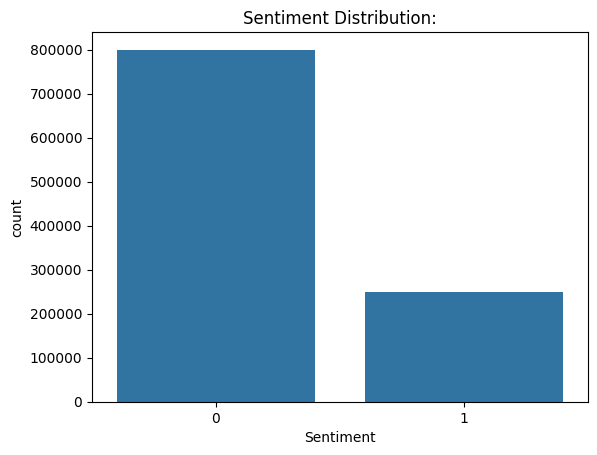

In [ ]:
sns.countplot(x="Sentiment", data=df)
plt.title("Sentiment Distribution:")
plt.show()

In [ ]:
major = df[df["Sentiment"] == 0]
minor = df[df["Sentiment"] == 1]

In [ ]:
major.shape

(799996, 2)

In [ ]:
major_new = resample(major, replace=False, n_samples=len(minor), random_state=52)

In [ ]:
df = pd.concat([major_new, minor])
df

,Sentiment,text
104838,0,why doesn't family channel of &quot;Jonas&quo...
84744,0,I am back! After realizing that my comp sucks
699886,0,is so tired after only four hours sleep and a ...
714803,0,The old girl is having trouble getting used to...
734913,0,morning insomnia is starting to get the better...
...,...,...
1048567,1,My GrandMa is making Dinenr with my Mum
1048568,1,Mid-morning snack time... A bowl of cheese noo...
1048569,1,@ShaDeLa same here say it like from the Termi...
1048570,1,@DestinyHope92 im great thaanks wbuu?


In [ ]:
tweets = df["text"].to_numpy()
sentiments = df["Sentiment"].to_numpy()

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(tweets)
sequences = tokenizer.texts_to_sequences(tweets)

In [ ]:
maxlen = max([len(seq) for seq in sequences])
maxlen

46

In [ ]:
X = pad_sequences(sequences, maxlen=maxlen)

LSTM

In [ ]:
#LSTM
embedding_dim = 16
model = tf.keras.Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=embedding_dim))
model.add(LSTM(512, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(256, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(1, activation="sigmoid"))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          4900832   
                                                                 
 lstm (LSTM)                 (None, None, 512)         1083392   
                                                                 
 dropout (Dropout)           (None, None, 512)         0         
                                                                 
 lstm_1 (LSTM)               (None, None, 256)         787456    
                                                                 
 dropout_1 (Dropout)         (None, None, 256)         0         
                                                                 
 lstm_2 (LSTM)               (None, None, 128)         197120    
                                                                 
 dropout_2 (Dropout)         (None, None, 128)         0

In [ ]:
Model: "sequential"

In [ ]:
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
model.fit(X, sentiments, epochs=9, batch_size=128)

Epoch 1/9
3884/3884 [==============================] - 177s 43ms/step - loss: 0.4411 - accuracy: 0.7935
Epoch 2/9
3884/3884 [==============================] - 139s 36ms/step - loss: 0.3136 - accuracy: 0.8671
Epoch 3/9
3884/3884 [==============================] - 138s 36ms/step - loss: 0.2356 - accuracy: 0.9044
Epoch 4/9
3884/3884 [==============================] - 138s 36ms/step - loss: 0.1902 - accuracy: 0.9236
Epoch 5/9
3884/3884 [==============================] - 139s 36ms/step - loss: 0.1579 - accuracy: 0.9370
Epoch 6/9
3884/3884 [==============================] - 140s 36ms/step - loss: 0.1324 - accuracy: 0.9472
Epoch 7/9
3884/3884 [==============================] - 139s 36ms/step - loss: 0.1125 - accuracy: 0.9552
Epoch 8/9
3884/3884 [==============================] - 139s 36ms/step - loss: 0.0976 - accuracy: 0.9610
Epoch 9/9
3884/3884 [==============================] - 138s 35ms/step - loss: 0.0860 - accuracy: 0.9655


In [ ]:
new_text = "The movie was not that bad"

new_sequence = tokenizer.texts_to_sequences([new_text])
new_X = pad_sequences(new_sequence, maxlen=maxlen)

prediction = model.predict(new_X)[0][0]

if prediction >= 0.5:
    pred_sen = 'positive'
else:
    pred_sen = 'negative'

final_prediction = prediction * 100
round_pred = round(final_prediction, 2)

print(f'Input text: {new_text}')
if pred_sen == "positive":
    print(f'Predicted sentiment: {pred_sen} (confidence: {round_pred})')
else:
    print(f'Predicted sentiment: {pred_sen} (confidence: {100 - round_pred})')

1/1 [==============================] - 1s 1s/step
Input text: The movie was not that bad
Predicted sentiment: positive (confidence: 82.41)


GRU

In [ ]:
#GRU
embedding_dim = 16
model = tf.keras.Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=embedding_dim))
model.add(GRU(128, return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1, activation="sigmoid"))

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 16)          4900832   
                                                                 
 gru (GRU)                   (None, None, 128)         56064     
                                                                 
 dropout_4 (Dropout)         (None, None, 128)         0         
                                                                 
 gru_1 (GRU)                 (None, 64)                37248     
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4994209 (19.05 MB)
Trainable params: 499

In [ ]:
Model: "sequential"
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
model.fit(X, sentiments, epochs=9, batch_size=128)

Epoch 1/9
3884/3884 [==============================] - 58s 14ms/step - loss: 0.4368 - accuracy: 0.7959
Epoch 2/9
3884/3884 [==============================] - 39s 10ms/step - loss: 0.3050 - accuracy: 0.8714
Epoch 3/9
3884/3884 [==============================] - 37s 10ms/step - loss: 0.2219 - accuracy: 0.9100
Epoch 4/9
3884/3884 [==============================] - 38s 10ms/step - loss: 0.1754 - accuracy: 0.9296
Epoch 5/9
3884/3884 [==============================] - 36s 9ms/step - loss: 0.1456 - accuracy: 0.9419
Epoch 6/9
3884/3884 [==============================] - 38s 10ms/step - loss: 0.1226 - accuracy: 0.9512
Epoch 7/9
3884/3884 [==============================] - 39s 10ms/step - loss: 0.1046 - accuracy: 0.9584
Epoch 8/9
3884/3884 [==============================] - 39s 10ms/step - loss: 0.0909 - accuracy: 0.9639
Epoch 9/9
3884/3884 [==============================] - 38s 10ms/step - loss: 0.0803 - accuracy: 0.9680


In [ ]:
new_text = "The movie was not that bad"

new_sequence = tokenizer.texts_to_sequences([new_text])
new_X = pad_sequences(new_sequence, maxlen=maxlen)

prediction = model.predict(new_X)[0][0]

if prediction >= 0.5:
    pred_sen = 'positive'
else:
    pred_sen = 'negative'

final_prediction = prediction * 100
round_pred = round(final_prediction, 2)

print(f'Input text: {new_text}')
if pred_sen == "positive":
    print(f'Predicted sentiment: {pred_sen} (confidence: {round_pred})')
else:
    print(f'Predicted sentiment: {pred_sen} (confidence: {100 - round_pred})')

1/1 [==============================] - 0s 22ms/step
Input text: The movie was not that bad
Predicted sentiment: positive (confidence: 91.37)
